# Introduction 

In [ ]:
Tree(5), grass(10), water(22), plant,flora, plant life (18)

# Set up Environment

In [45]:
import os,json,ast, csv, torch, scipy.io, PIL.Image, torchvision.transforms
import numpy as np
import pandas as pd 
# ADE20k Image Segmentation Libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

# Loading Segmentation Models

In [2]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

# Load Example Test Images

In [3]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('./data/ADEChallengeData2016/images/validation/ADE_val_00001519.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

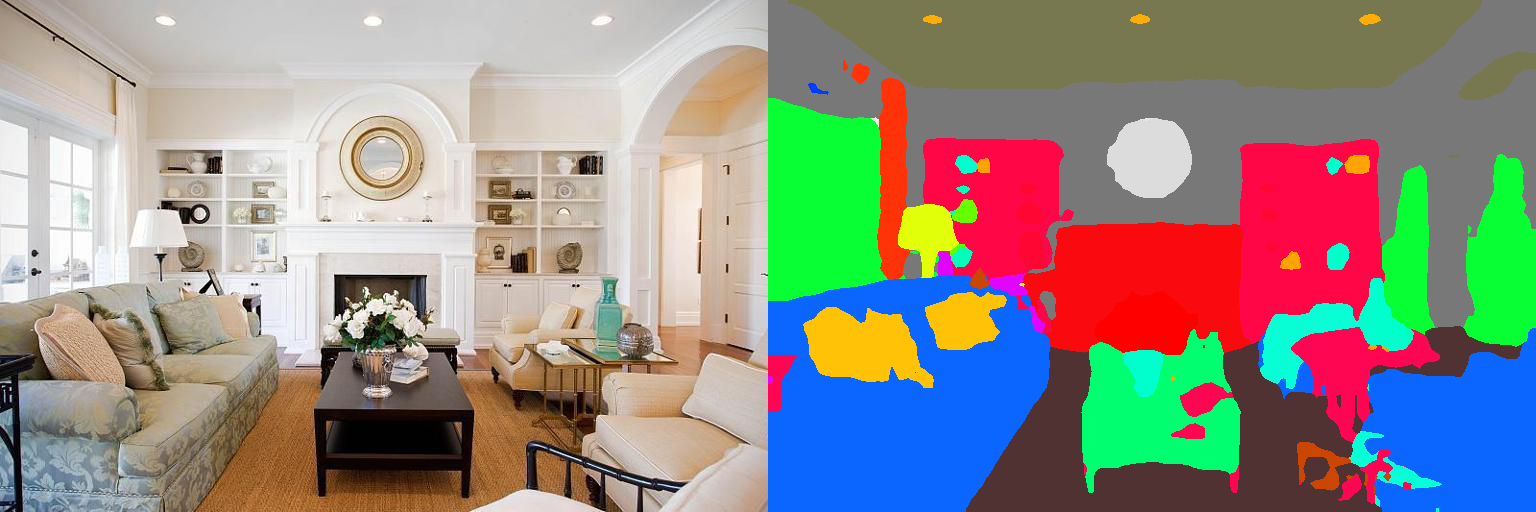

In [4]:
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

In [12]:
print(pred)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [23 23 23 ... 23 23 23]
 [23 23 23 ... 23 23 23]
 [23 23 23 ... 23 23 23]]


# DeepLabV3 

In [9]:
import importlib
import deeplab_model
importlib.reload(deeplab_model.deeplabv3)

<module 'deeplab_model.deeplabv3' from 'C:\\Users\\hturner\\Documents\\Projects\\BinaryImageSegmentation\\deeplab_model\\deeplabv3.py'>

In [8]:
from deeplab_model.deeplabv3 import DeepLabV3
net = DeepLabV3(num_classes=150)

In [10]:
print(img_data.shape)
print(img_data)

torch.Size([3, 512, 768])
tensor([[[ 0.5193, -0.1657, -1.2274,  ...,  1.0502,  1.0502,  1.0502],
         [ 0.3138,  0.5022,  0.4166,  ...,  1.0673,  1.0502,  1.0502],
         [ 0.4166,  0.4337,  0.6563,  ...,  1.0673,  1.0673,  1.0502],
         ...,
         [-0.2513, -0.4054, -0.5082,  ...,  0.7591,  0.7762,  0.7077],
         [-0.7479, -0.6109, -0.5424,  ...,  0.7762,  0.7248,  0.6734],
         [-1.0733, -0.7137, -0.6452,  ...,  0.7419,  0.7077,  0.6563]],

        [[ 0.3452, -0.3550, -1.4230,  ...,  1.2031,  1.2031,  1.2031],
         [ 0.1527,  0.3452,  0.2577,  ...,  1.2206,  1.2031,  1.2031],
         [ 0.2577,  0.2752,  0.5028,  ...,  1.2206,  1.2206,  1.2031],
         ...,
         [ 0.2927,  0.1352, -0.0049,  ...,  0.5028,  0.5203,  0.5028],
         [-0.1800, -0.0749, -0.0399,  ...,  0.5203,  0.5203,  0.4678],
         [-0.5126, -0.1450, -0.0924,  ...,  0.5378,  0.5028,  0.4503]],

        [[ 0.4962, -0.2010, -1.3164,  ...,  1.3851,  1.3851,  1.3851],
         [ 0.2522, 

torch.Size([1, 256, 32, 48])


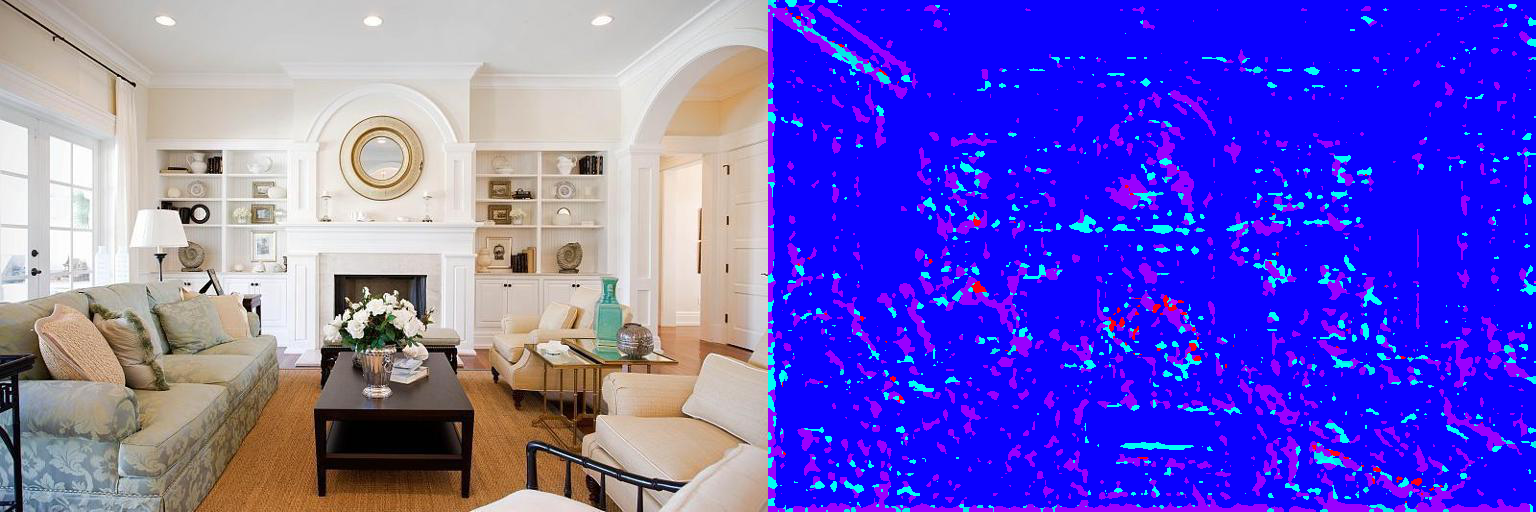

In [48]:
net.eval()
with torch.no_grad():
    output = net(img_data[None])
_, pred = torch.max(output, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

# Parse Dataset

In [15]:
object_data = pd.read_csv("./data/object150_info.csv")

In [23]:
object_data.sort_values(by=['Train'],ascending=False).head(30)

,Idx,Ratio,Train,Val,Stuff,Name
0,1,0.1576,11664,1172,1,wall
3,4,0.0621,9336,917,1,floor;flooring
2,3,0.0878,8265,796,1,sky
4,5,0.0480,6678,641,0,tree
14,15,0.0118,6666,796,0,door;double;door
5,6,0.0450,6604,643,1,ceiling
1,2,0.1072,6046,612,1,building;edifice
12,13,0.0160,5075,526,0,person;individual;someone;somebody;mortal;soul
8,9,0.0198,4688,460,0,windowpane;window
15,16,0.0110,4269,411,0,table


In [24]:
"""
Object: DF Index, IDx
Sky: 2,3
Tree: 4,5
Building: 1,2
Person: 12,13
Road: 6,7
Car: 20,21
Light: 82,83
"""
included_classes = {'Sky': 3, 'Tree':5, 'Building':2, 'Person':13,'Road':7,'Car':21,'Light':83}

In [43]:
def checkImage(path):
    labels = np.array(PIL.Image.open("./data/" + path))
    for idx in included_classes.values():
        if idx in labels:
            return True
    return False

In [65]:
def makeODGT(img_list,target_path):
    with open('./data/' + target_path,'w+') as f:
        for img_data in img_list:
            f.write(json.dumps(img_data) + "\n")

In [26]:
with open('./data/training.odgt', 'r+') as f:
    train_data = f.readlines()
with open('./data/validation.odgt', 'r+') as f:
    val_data = f.readlines()

In [39]:
test_image = np.array(PIL.Image.open("./data/ADEChallengeData2016/annotations/training/ADE_train_00000001.png"))
print(np.min(test_image))

0


In [59]:
json.loads(train_data[0])

{'fpath_img': 'ADEChallengeData2016/images/training/ADE_train_00000001.jpg',
 'fpath_segm': 'ADEChallengeData2016/annotations/training/ADE_train_00000001.png',
 'width': 683,
 'height': 512}

In [61]:
limited_train_data = []
excluded = 0
for data in train_data:
    if checkImage(json.loads(data)['fpath_segm']):
        limited_train_data.append(json.loads(data))
    else:
        excluded+=1
#TEST
print((excluded+len(limited_train_data))==len(train_data))

True


In [62]:
limited_val_data = []
val_excluded = 0
for data in val_data:
    if checkImage(json.loads(data)['fpath_segm']):
        limited_val_data.append(json.loads(data))
    else:
        val_excluded+=1
#TEST
print((val_excluded+len(limited_val_data))==len(val_data))

True


In [66]:
makeODGT(limited_train_data,'limited_train.odgt')
makeODGT(limited_val_data,'limited_val.odgt')